<a href="https://colab.research.google.com/github/racego/AIRE_LAURA_SEMANA_5_ANALISIS/blob/main/INFORME_AIRE_EDA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 PASO 1: INSTALANDO E IMPORTANDO LIBRERÍAS...
 Librerías instaladas e importadas correctamente

 CONFIGURANDO PARÁMETROS IBOCA...

 PASO 2: CARGANDO DATOS DESDE GOOGLE SHEETS...
 Accediendo a Google Sheets...
 Error: APIError: [400]: This operation is not supported for this document
 Usando datos de ejemplo...
 Datos de ejemplo creados para análisis

🔧 PASO 3: PREPROCESAMIENTO Y CÁLCULO DEL IBOCA...
 Estaciones identificadas: ['Carvajal', 'Ciudad Bolivar', 'Fontibon', 'Kennedy']
 Calculando índices IBOCA...
 IBOCA PM2.5 calculado: 1453 valores
 IBOCA PM10 calculado: 1454 valores
 IBOCA máximo calculado: 1460 valores

 PASO 4: ANÁLISIS ESTADÍSTICO CON IBOCA

 ANÁLISIS COMPLETO CON IBOCA: CARVAJAL

 PM2.5 - Carvajal:
   Concentración: Media=25.1 µg/m³, Mediana=25.5 µg/m³
   IBOCA: Media=78.2, Mediana=79.0
   Categorías IBOCA PM2.5:
     Amarillo: 322 registros (88.2%)
     Naranja: 28 registros (7.7%)
     Verde: 11 registros (3.0%)
     Rojo: 1 registros (0.3%)

 PM10 - Carvajal:
   Con

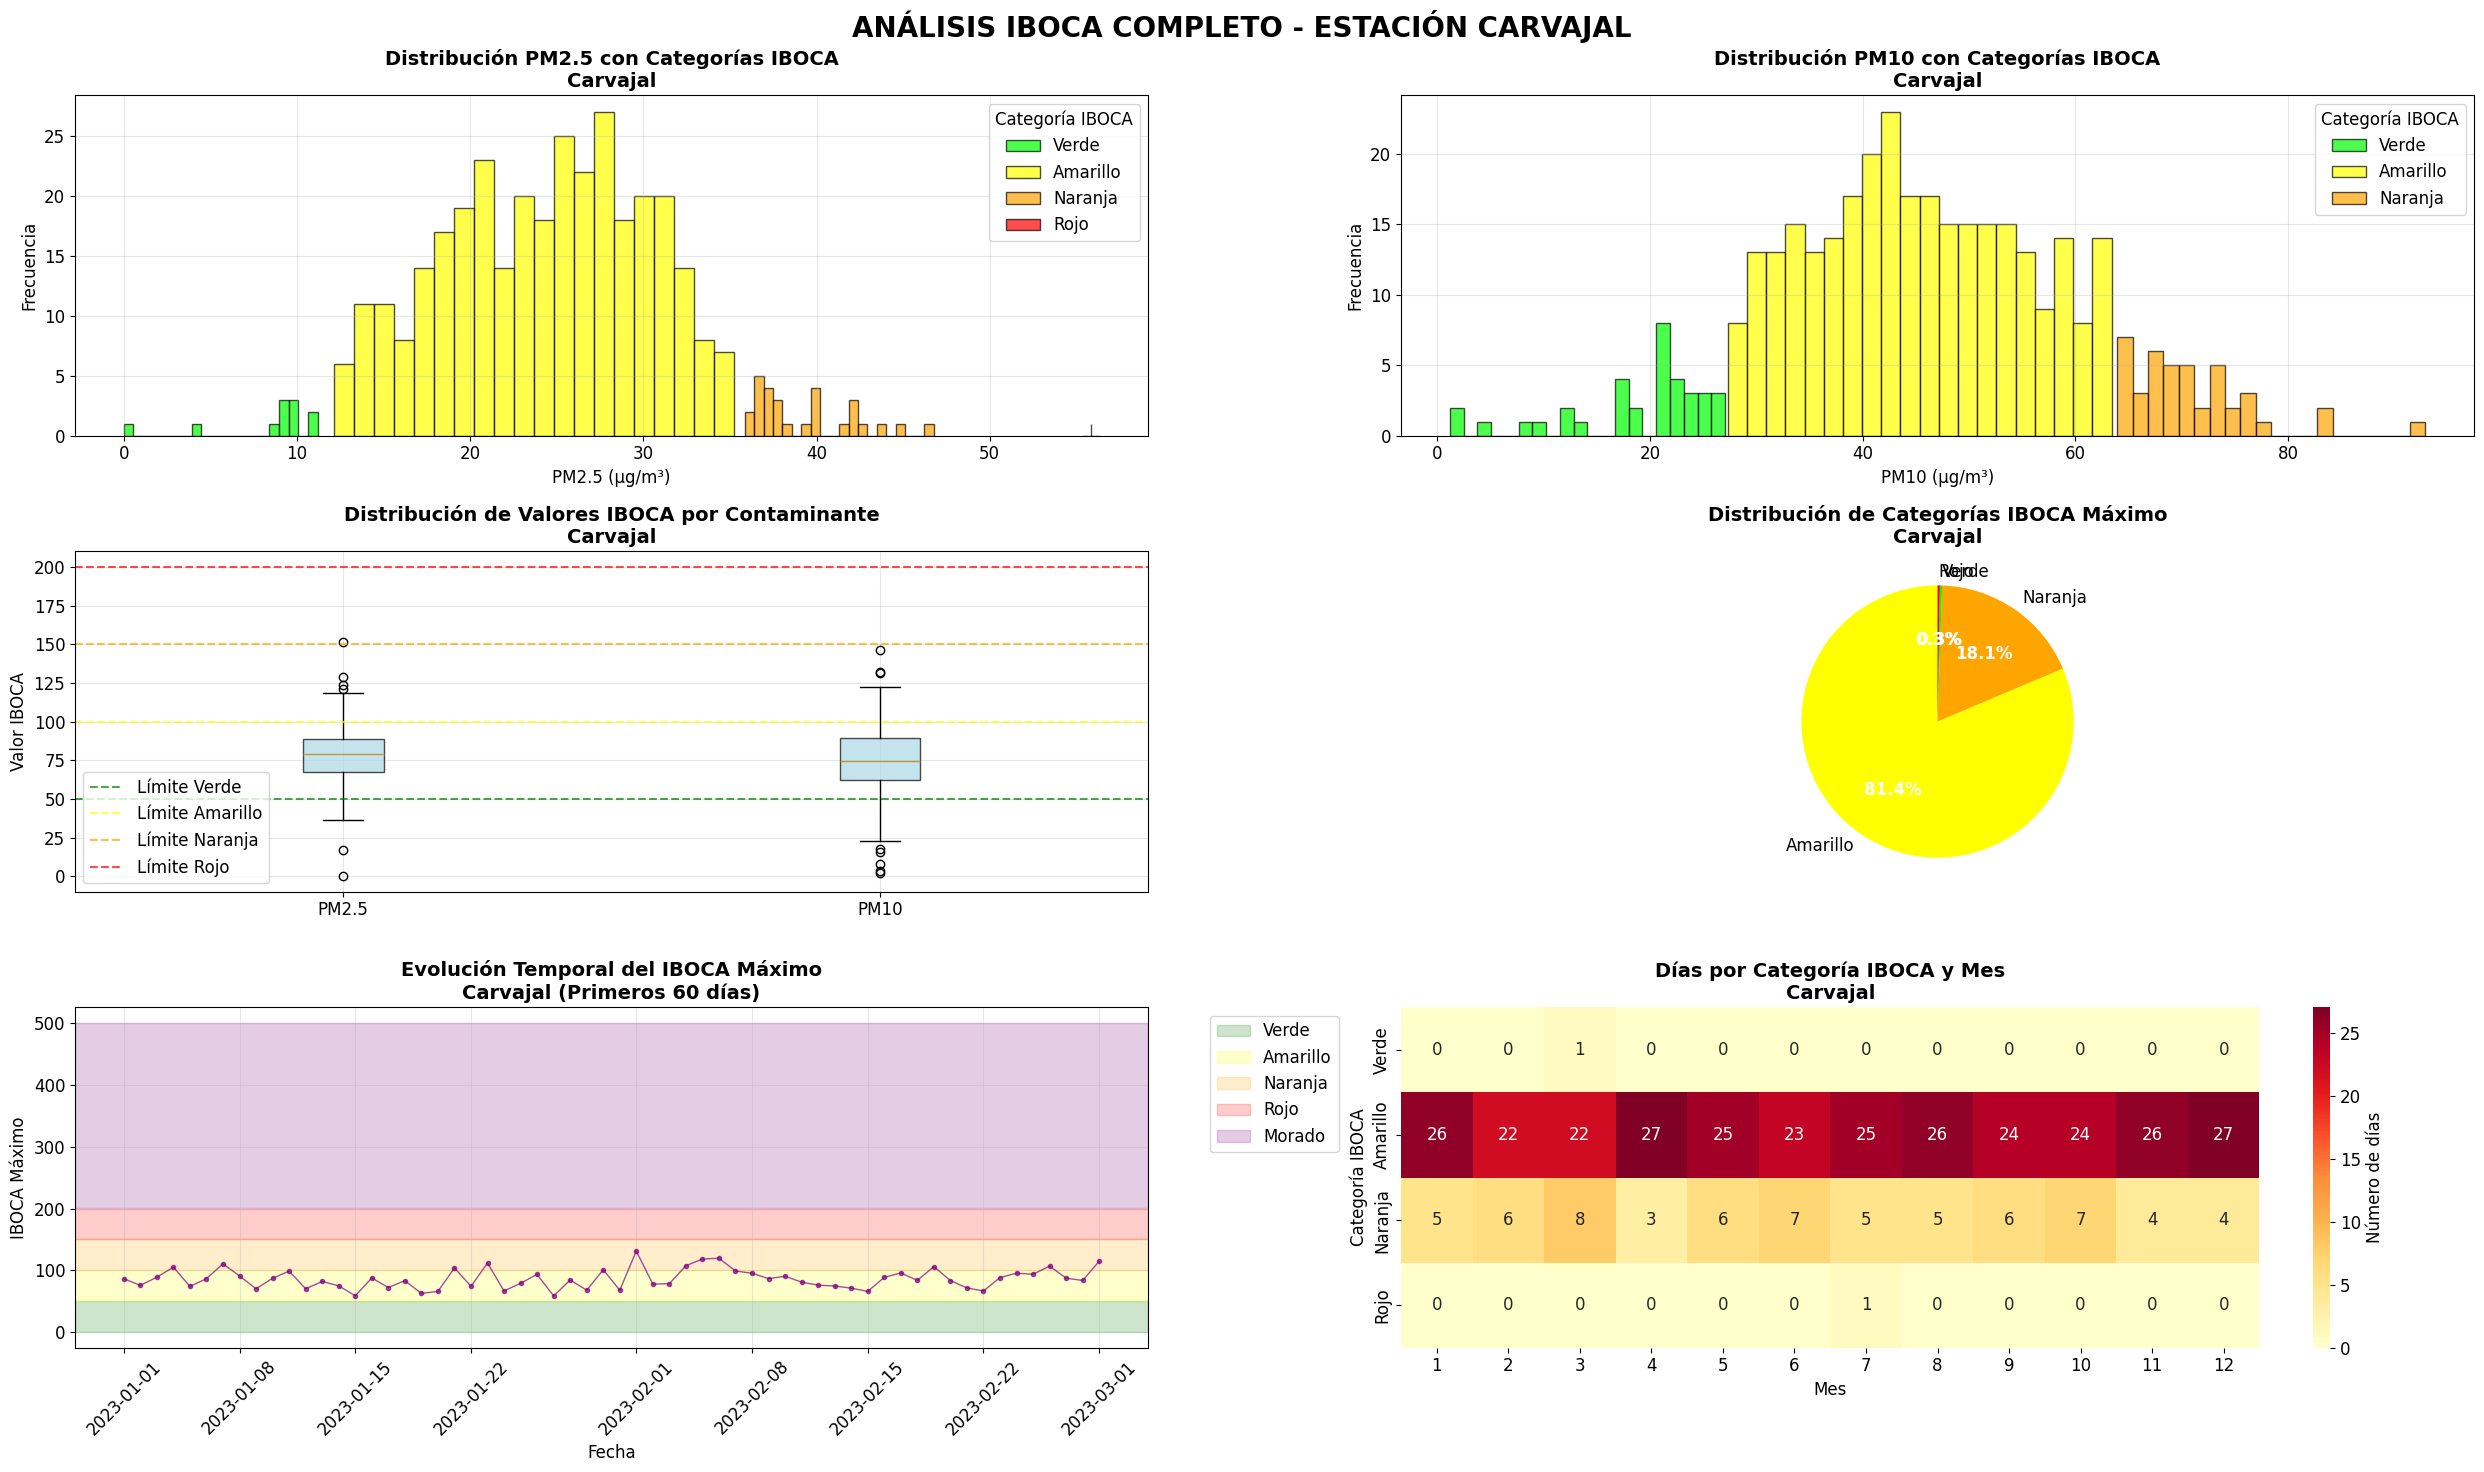

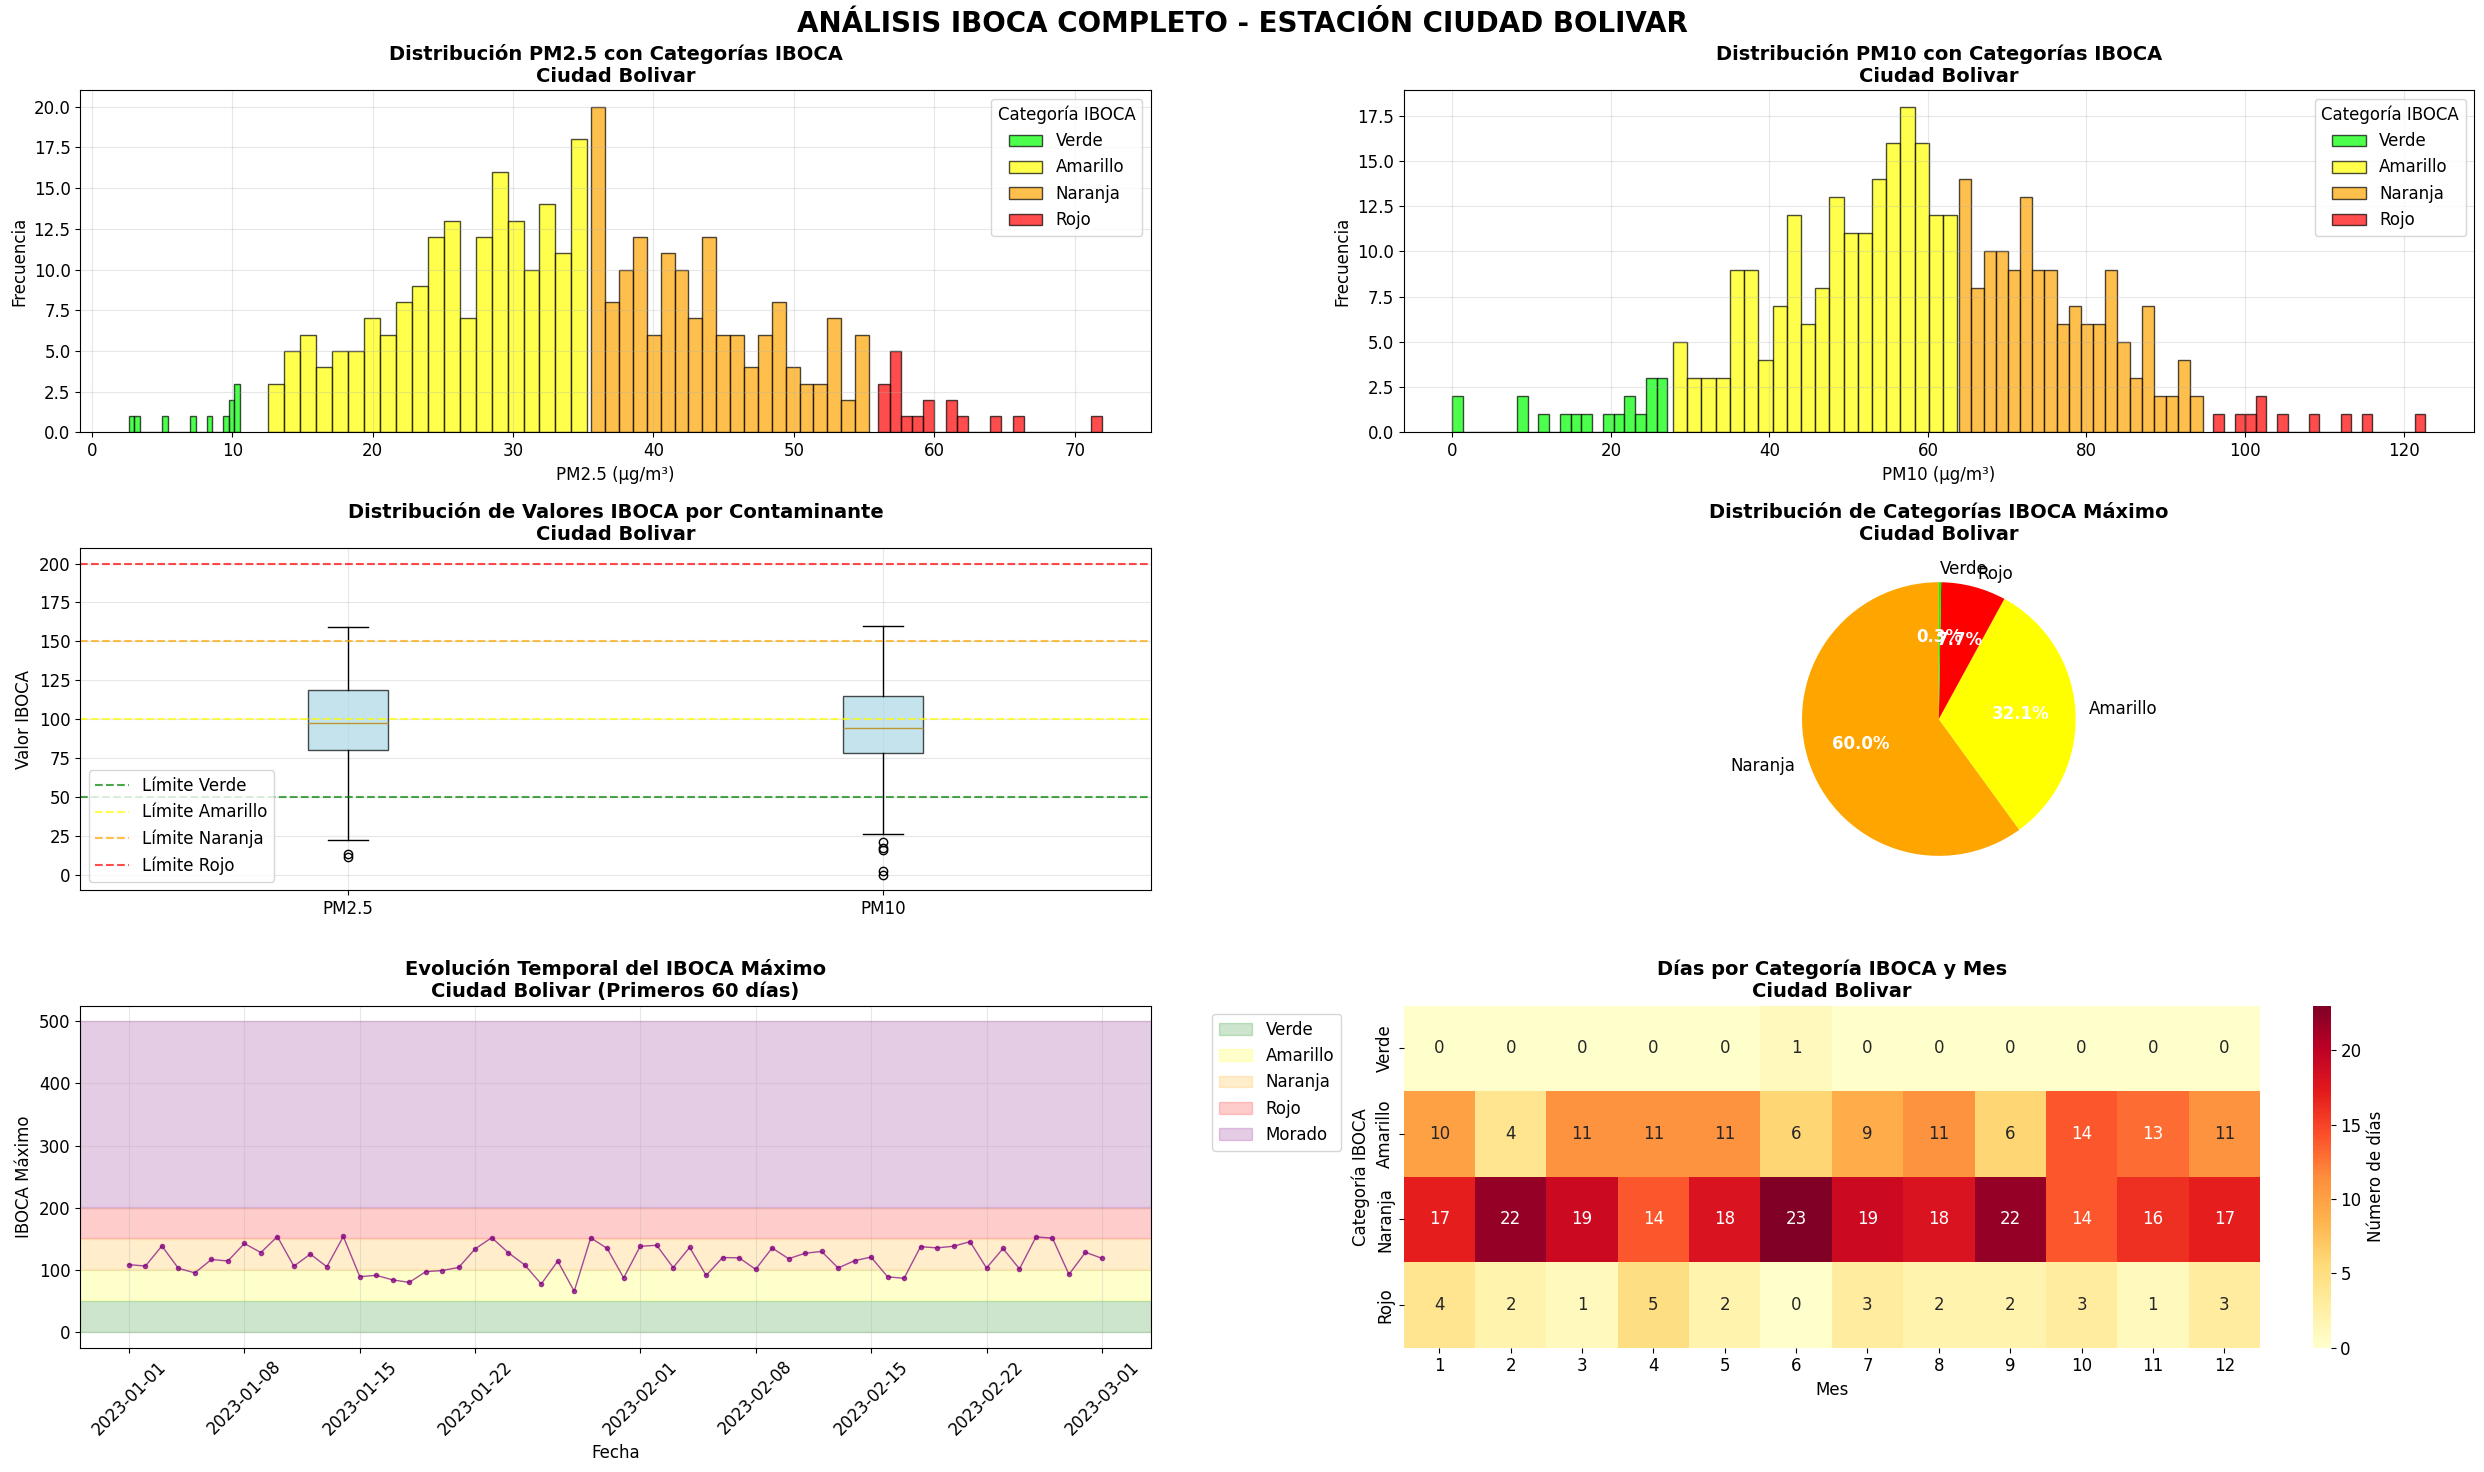

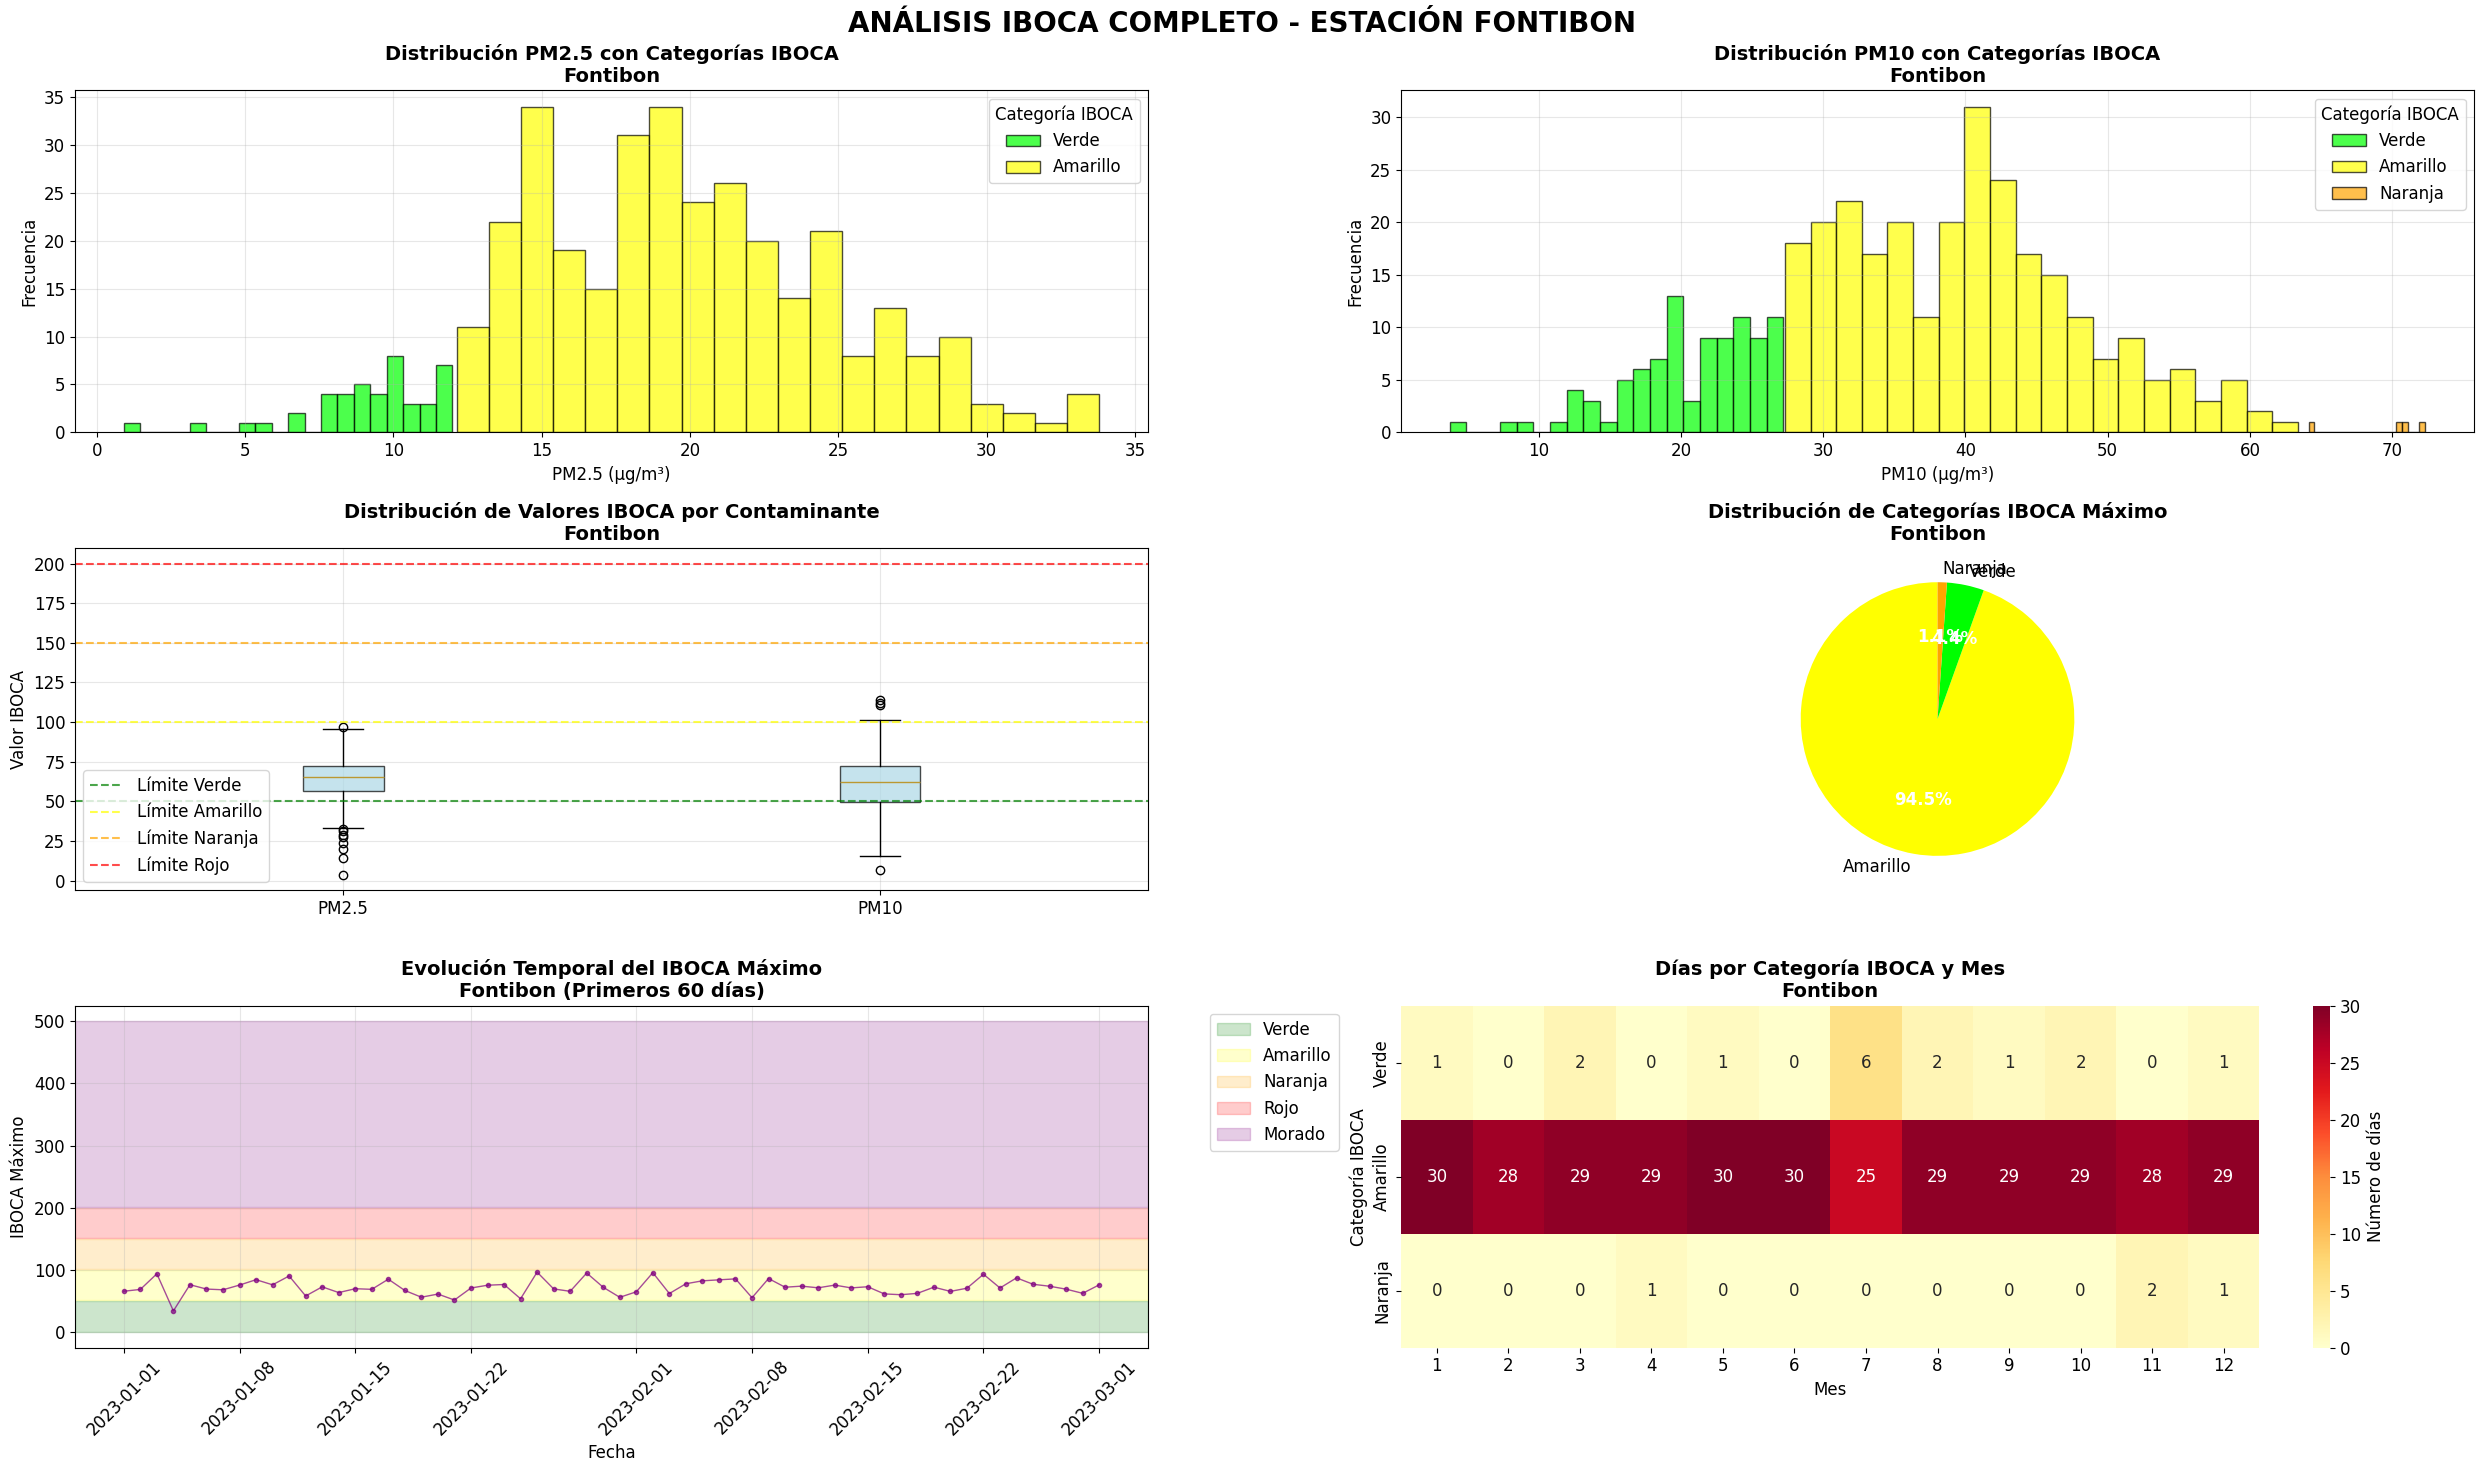

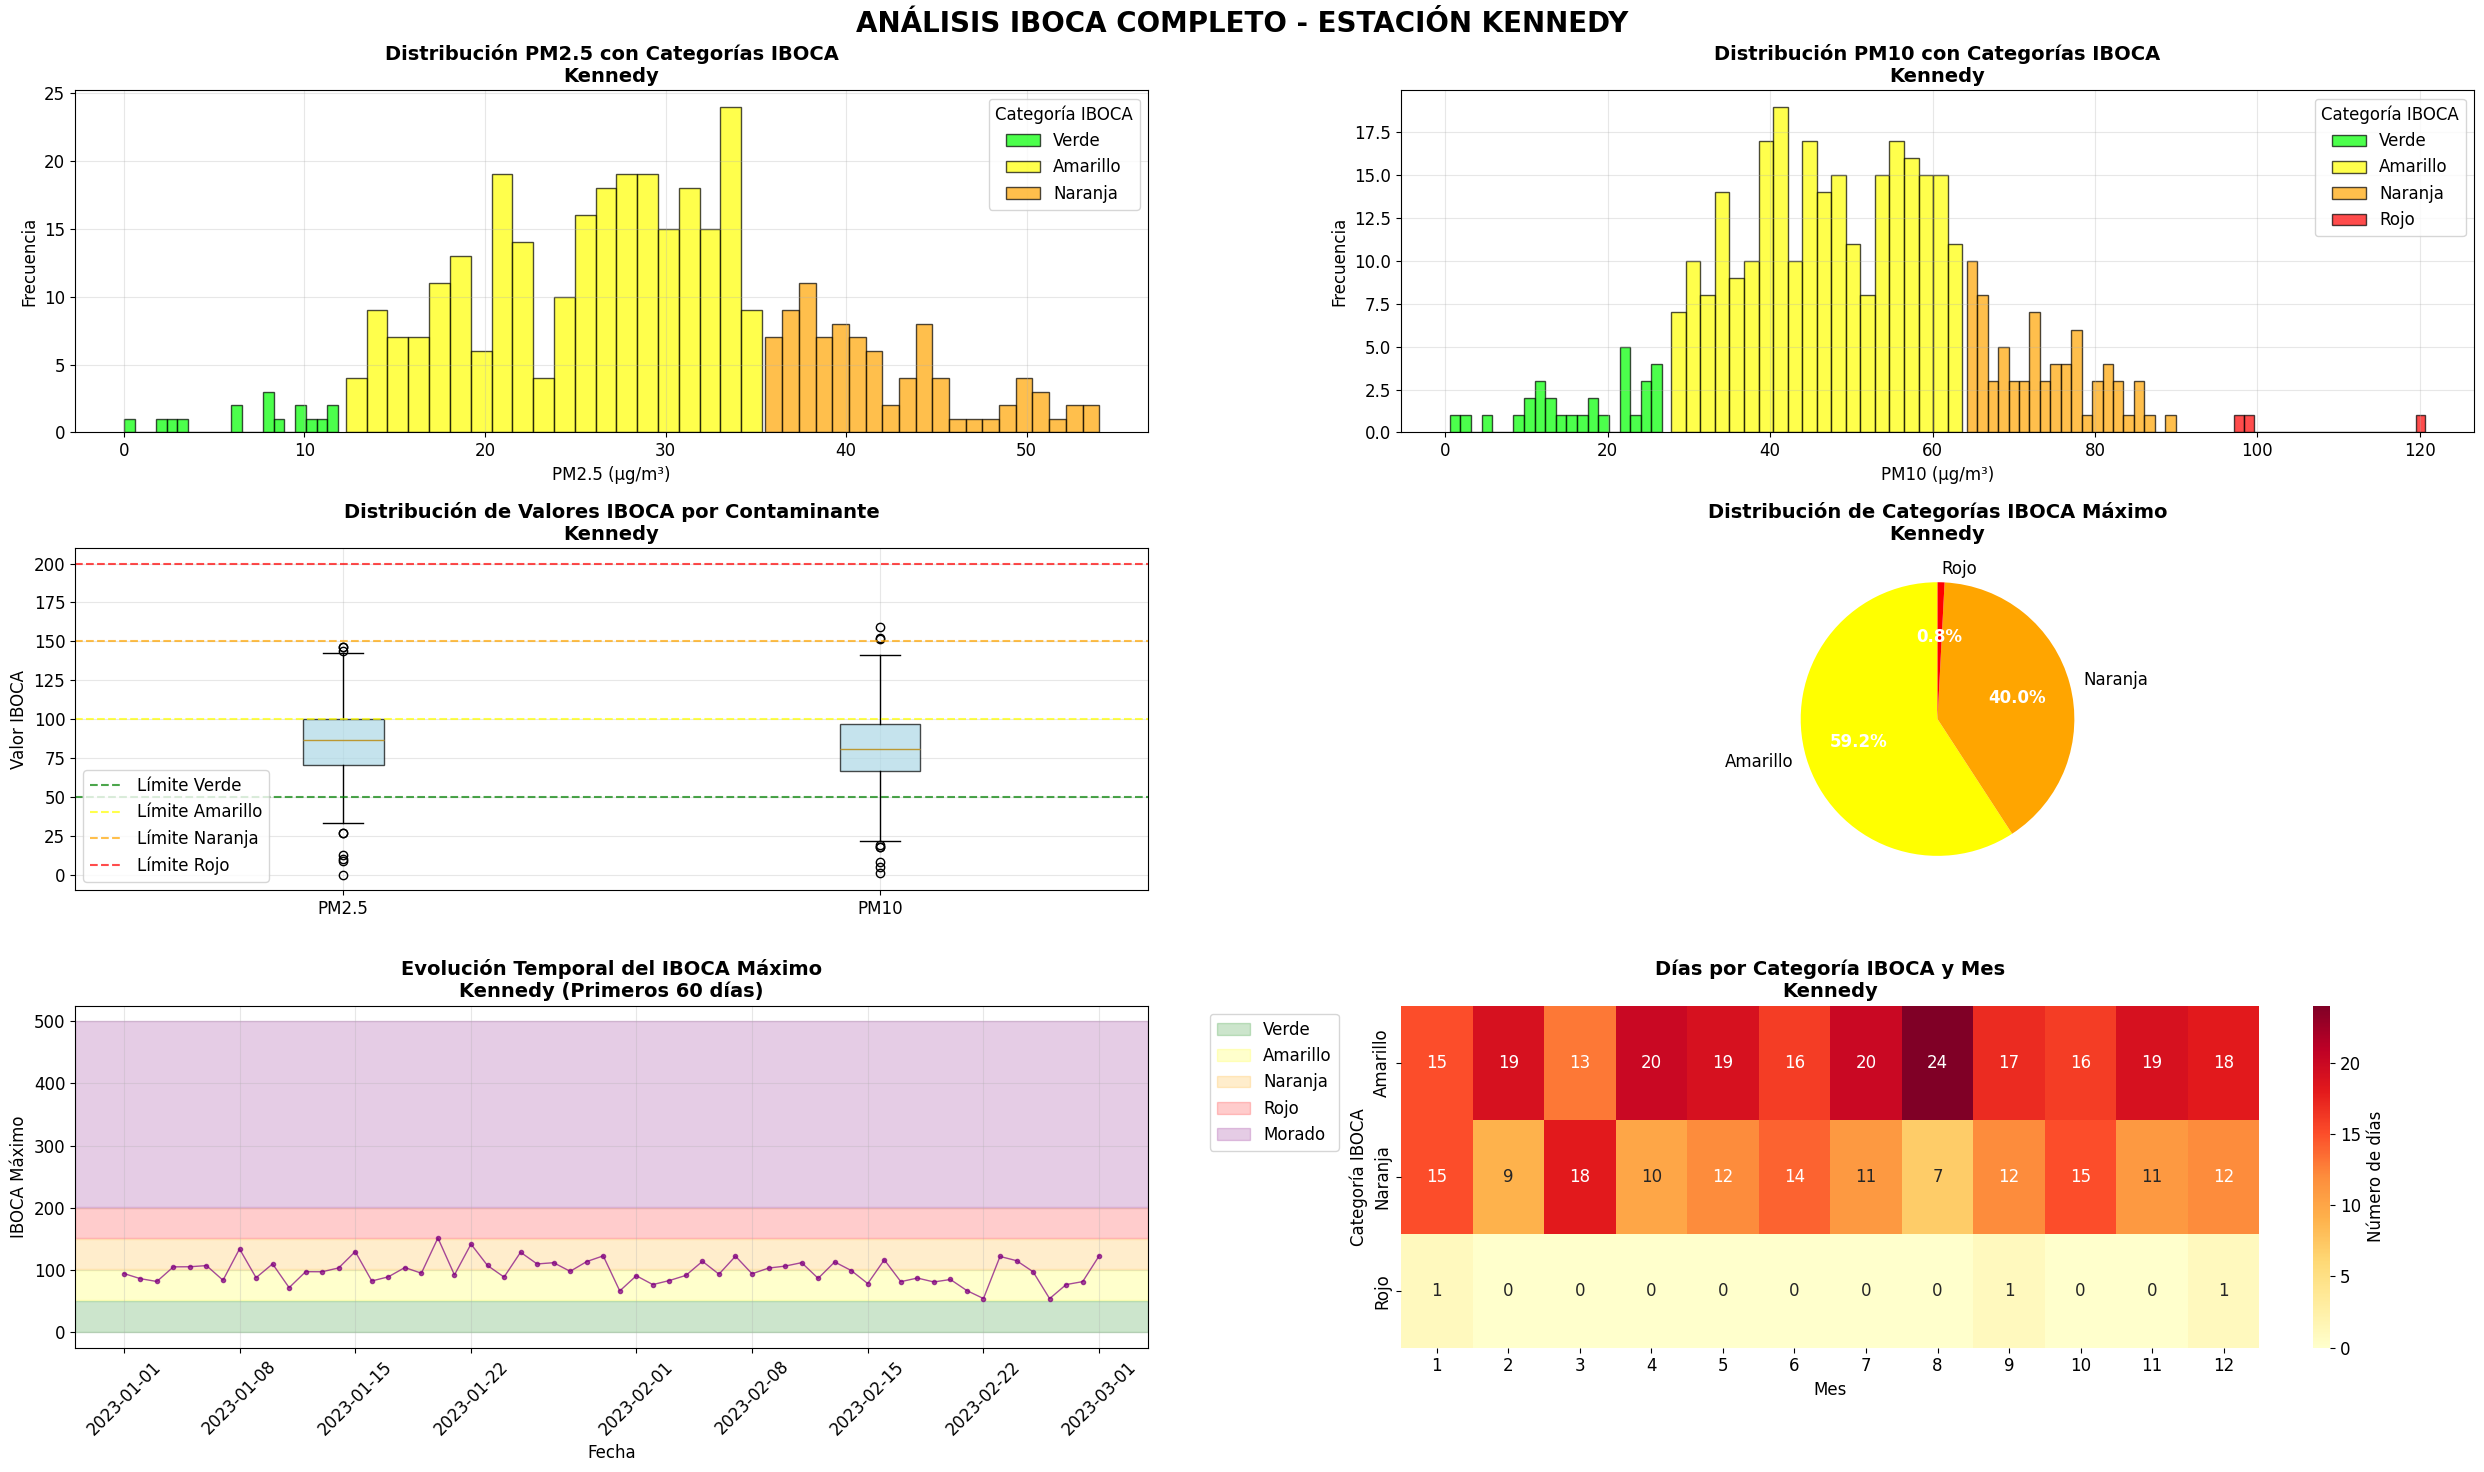


 PASO 6: GRÁFICAS COMPARATIVAS ENTRE ESTACIONES


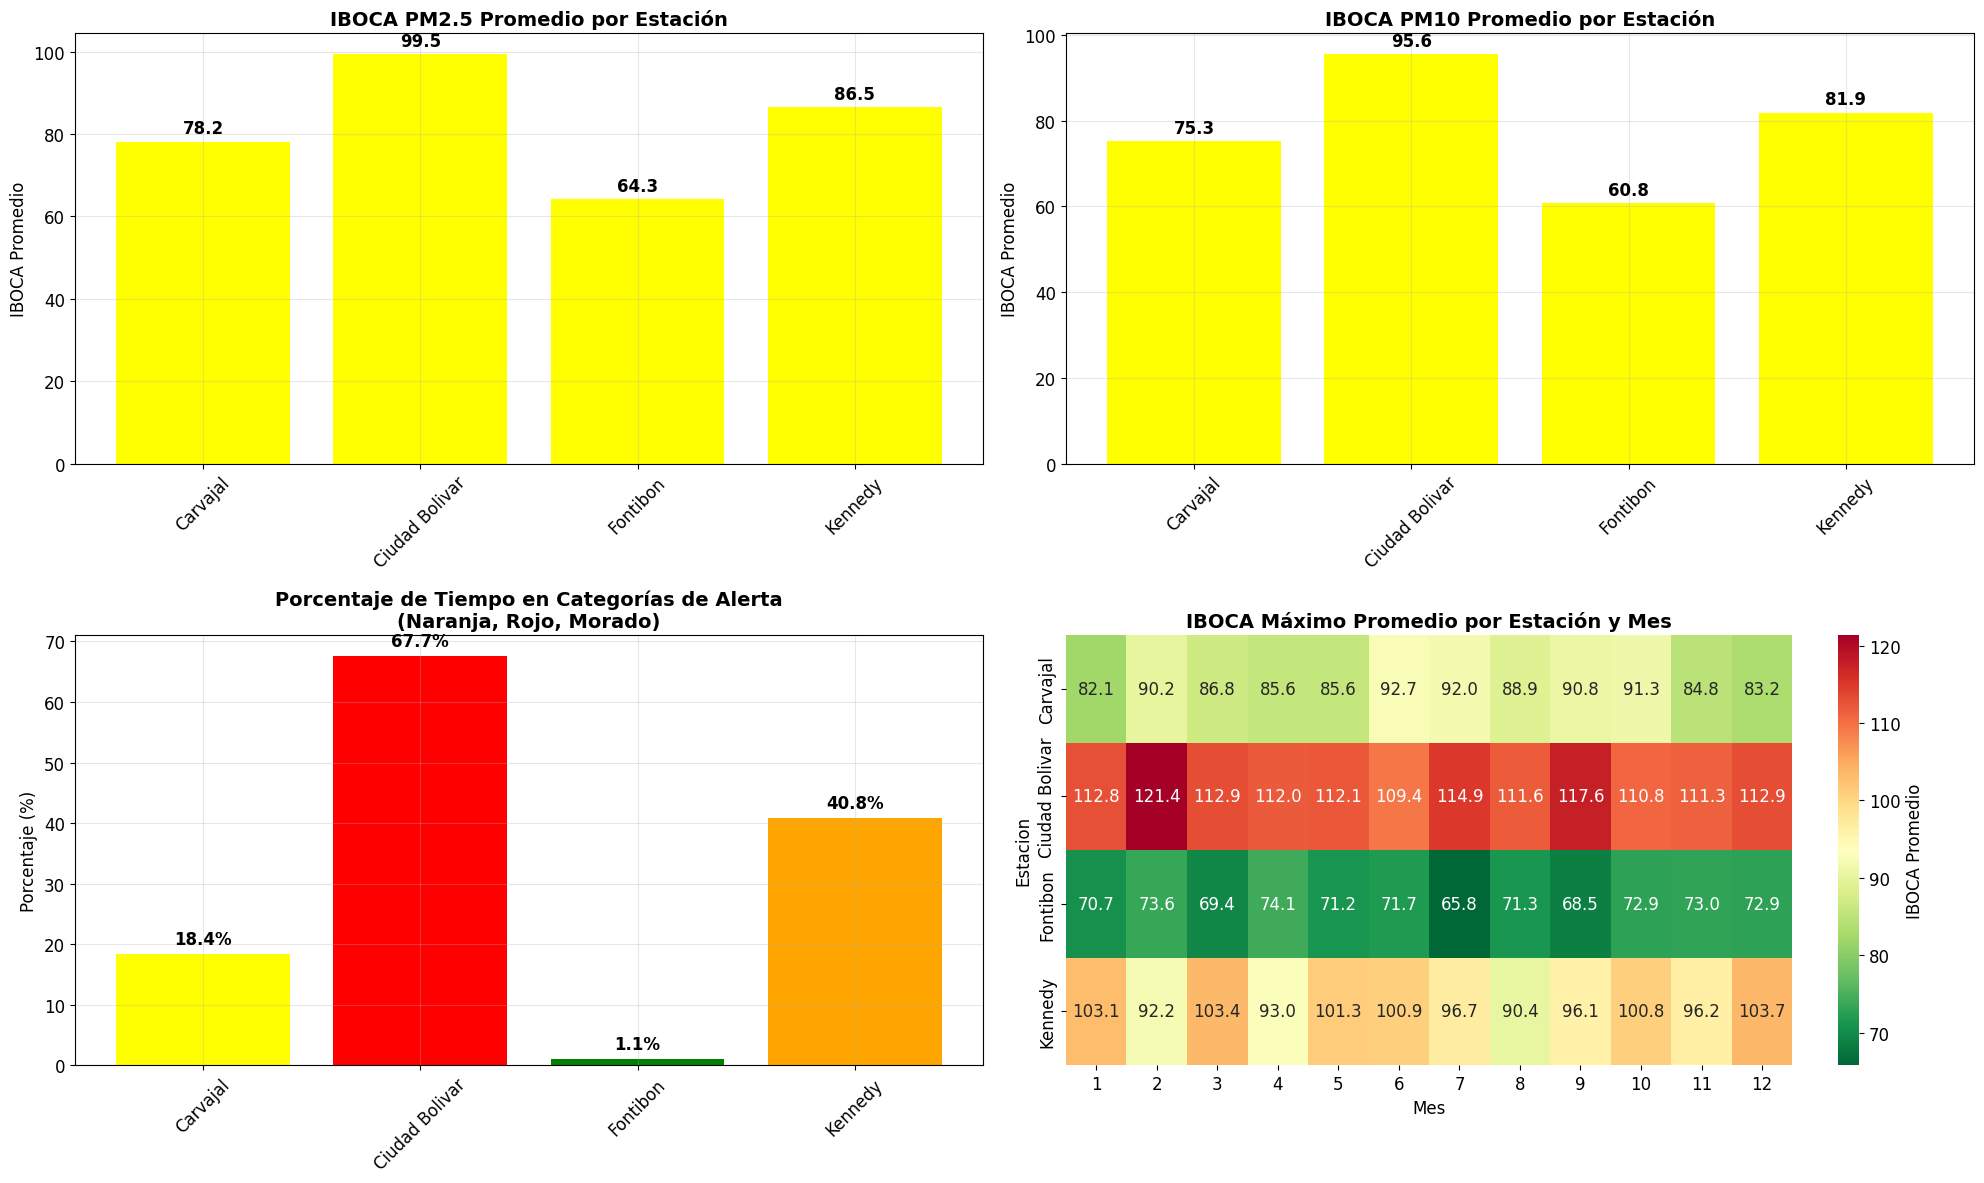


 PASO 7: TABLAS DE CONTINGENCIA CON IBOCA

 TABLAS DE CONTINGENCIA - CATEGORÍAS IBOCA MÁXIMO:

 TABLA ABSOLUTA (número de días):
Categoria_MAX   Amarillo  Naranja  Rojo  Verde   All
Estacion                                            
Carvajal             297       66     1      1   365
Ciudad Bolivar       117      219    28      1   365
Fontibon             345        4     0     16   365
Kennedy              216      146     3      0   365
All                  975      435    32     18  1460

 TABLA RELATIVA POR FILA (%):
Categoria_MAX   Amarillo  Naranja  Rojo  Verde
Estacion                                      
Carvajal           81.37    18.08  0.27   0.27
Ciudad Bolivar     32.05    60.00  7.67   0.27
Fontibon           94.52     1.10  0.00   4.38
Kennedy            59.18    40.00  0.82   0.00

 TABLA RELATIVA POR COLUMNA (%):
Categoria_MAX   Amarillo  Naranja   Rojo  Verde
Estacion                                       
Carvajal           30.46    15.17   3.12   5.56
Ciudad B

In [4]:
# PASO 1: INSTALACIÓN E IMPORTACIÓN DE LIBRERÍAS
print(" PASO 1: INSTALANDO E IMPORTANDO LIBRERÍAS...")

!pip install gspread google-auth > /dev/null 2>&1
!pip install seaborn > /dev/null 2>&1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración para mejores gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(" Librerías instaladas e importadas correctamente")

# =============================================================================
# CONFIGURACIÓN IBOCA SEGÚN TABLA OFICIAL
# =============================================================================

print("\n CONFIGURANDO PARÁMETROS IBOCA...")

# Configuración IBOCA basada en la tabla proporcionada
IBOCA_CATEGORIAS = {
    'Verde': {
        'range': (0, 50),
        'color': '#00FF00',
        'riesgo': 'Bajo',
        'respuesta': 'Prevención',
        'limites': {
            'PM25': (0, 12.0),
            'PM10': (0, 27.2),
            'O3': (0, 72),
            'NO2': (0, 28.5),
            'SO2': (0, 9.6),
            'CO': (0, 2549)
        }
    },
    'Amarillo': {
        'range': (51, 100),
        'color': '#FFFF00',
        'riesgo': 'Moderado',
        'respuesta': 'Prevención',
        'limites': {
            'PM25': (12.1, 35.4),
            'PM10': (27.3, 63.8),
            'O3': (73, 107),
            'NO2': (28.6, 84.1),
            'SO2': (9.7, 38.5),
            'CO': (2550, 5022)
        }
    },
    'Naranja': {
        'range': (101, 150),
        'color': '#FFA500',
        'riesgo': 'Regular',
        'respuesta': 'Alerta Fase 1',
        'limites': {
            'PM25': (35.5, 55.4),
            'PM10': (63.9, 95.5),
            'O3': (108, 137),
            'NO2': (84.2, 132.2),
            'SO2': (38.6, 63.5),
            'CO': (5023, 7165)
        }
    },
    'Rojo': {
        'range': (151, 200),
        'color': '#FF0000',
        'riesgo': 'Alto',
        'respuesta': 'Alerta Fase 2',
        'limites': {
            'PM25': (55.5, 151.2),
            'PM10': (95.6, 246.7),
            'O3': (138, 281),
            'NO2': (132.3, 361.9),
            'SO2': (63.6, 182.7),
            'CO': (7166, 17384)
        }
    },
    'Morado': {
        'range': (201, 300),
        'color': '#800080',
        'riesgo': 'Peligroso',
        'respuesta': 'Emergencia',
        'limites': {
            'PM25': (151.3, 250.4),
            'PM10': (246.8, 405.2),
            'O3': (282, 432),
            'NO2': (362.0, 602.6),
            'SO2': (182.8, 307.7),
            'CO': (17385, 28099)
        }
    },
    'Morado+': {
        'range': (301, 500),
        'color': '#4B0082',
        'riesgo': 'Peligroso',
        'respuesta': 'Emergencia',
        'limites': {
            'PM25': (250.5, 500.4),
            'PM10': (405.3, 800.4),
            'O3': (433, 809),
            'NO2': (602.7, 1202.6),
            'SO2': (307.8, 619.2),
            'CO': (28100, 54802)
        }
    }
}

def calcular_iboca(concentracion, contaminante):
    """
    Calcular el índice IBOCA para una concentración dada
    """
    if pd.isna(concentracion) or concentracion < 0:
        return np.nan

    # Encontrar la categoría correspondiente
    for categoria, info in IBOCA_CATEGORIAS.items():
        limites = info['limites'][contaminante]
        if limites[0] <= concentracion <= limites[1]:
            # Interpolación lineal dentro de la categoría
            iboca_inf, iboca_sup = info['range']
            conc_inf, conc_sup = limites

            iboca = iboca_inf + ((iboca_sup - iboca_inf) / (conc_sup - conc_inf)) * (concentracion - conc_inf)
            return min(iboca, 500)  # Valor máximo del IBOCA es 500

    # Si está por encima del máximo, retornar 500
    return 500 if concentracion > IBOCA_CATEGORIAS['Morado+']['limites'][contaminante][1] else np.nan

def categorizar_iboca(valor_iboca):
    """
    Convertir valor IBOCA a categoría cualitativa
    """
    if pd.isna(valor_iboca):
        return np.nan

    for categoria, info in IBOCA_CATEGORIAS.items():
        if info['range'][0] <= valor_iboca <= info['range'][1]:
            return categoria

    return 'Morado+' if valor_iboca > 300 else np.nan

def obtener_color_categoria(categoria):
    """Obtener color correspondiente a la categoría IBOCA"""
    return IBOCA_CATEGORIAS.get(categoria, {}).get('color', '#808080')

# PASO 2: CARGA DE DATOS DESDE GOOGLE SHEETS
print("\n PASO 2: CARGANDO DATOS DESDE GOOGLE SHEETS...")

def cargar_datos_desde_sheets():
    try:
        import gspread
        from google.colab import auth
        from google.auth import default

        # Autenticación
        auth.authenticate_user()
        gc = gspread.authorize(default()[0])

        # ID del documento
        sheet_id = "1XQaAwhm42n3-8O5s_M9rYCq2iEkTrivY"

        print(" Accediendo a Google Sheets...")
        sh = gc.open_by_key(sheet_id)
        worksheet = sh.sheet1

        # Obtener todos los datos
        datos = worksheet.get_all_records()
        df = pd.DataFrame(datos)

        print(f" Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df

    except Exception as e:
        print(f" Error: {e}")
        print(" Usando datos de ejemplo...")
        return crear_datos_ejemplo()

def crear_datos_ejemplo():
    """Crear datos de ejemplo realistas para las estaciones de Bogotá"""
    np.random.seed(42)

    # Crear fechas para un año completo
    fechas = pd.date_range('2023-01-01', '2023-12-31', freq='D')
    n_registros = len(fechas)

    # Datos realistas para cada estación basados en patrones típicos de Bogotá
    datos = {
        'Fecha': np.tile(fechas, 4),
        'Estacion': (['Carvajal'] * n_registros +
                    ['Ciudad Bolivar'] * n_registros +
                    ['Fontibon'] * n_registros +
                    ['Kennedy'] * n_registros),
        'PM25': np.concatenate([
            # Carvajal - niveles moderados (10-40 µg/m³)
            np.random.normal(25, 8, n_registros),
            # Ciudad Bolivar - niveles más altos (15-60 µg/m³)
            np.random.normal(35, 12, n_registros),
            # Fontibon - niveles moderados-bajos (8-30 µg/m³)
            np.random.normal(18, 6, n_registros),
            # Kennedy - niveles variables (12-45 µg/m³)
            np.random.normal(28, 10, n_registros)
        ]),
        'PM10': np.concatenate([
            # Carvajal (20-70 µg/m³)
            np.random.normal(45, 15, n_registros),
            # Ciudad Bolivar (30-90 µg/m³)
            np.random.normal(60, 20, n_registros),
            # Fontibon (15-60 µg/m³)
            np.random.normal(35, 12, n_registros),
            # Kennedy (25-80 µg/m³)
            np.random.normal(50, 18, n_registros)
        ])
    }

    # Asegurar valores positivos
    datos['PM25'] = np.maximum(datos['PM25'], 0)
    datos['PM10'] = np.maximum(datos['PM10'], 0)

    df = pd.DataFrame(datos)
    print(" Datos de ejemplo creados para análisis")
    return df

# Cargar datos
df = cargar_datos_desde_sheets()

# PASO 3: PREPROCESAMIENTO Y CÁLCULO DEL IBOCA
print("\n PASO 3: PREPROCESAMIENTO Y CÁLCULO DEL IBOCA...")

# Limpieza de nombres de columnas
df.columns = [col.strip().replace(' ', '_') for col in df.columns]

# Verificar y estandarizar nombres de estaciones
if 'Estacion' in df.columns:
    estaciones_originales = df['Estacion'].unique()
    print(f" Estaciones identificadas: {list(estaciones_originales)}")

    # Estandarizar nombres
    mapeo_estaciones = {
        'carvajal': 'Carvajal', 'CARVAJAL': 'Carvajal',
        'ciudad_bolivar': 'Ciudad Bolivar', 'CIUDAD BOLIVAR': 'Ciudad Bolivar',
        'fontibon': 'Fontibon', 'FONTIBON': 'Fontibon',
        'kennedy': 'Kennedy', 'KENNEDY': 'Kennedy'
    }

    df['Estacion'] = df['Estacion'].str.strip().replace(mapeo_estaciones)

# Verificar contaminantes y calcular IBOCA
contaminantes = ['PM25', 'PM10', 'PM2.5', 'pm25', 'pm10']
pm25_col = next((col for col in contaminantes if col in df.columns), None)
pm10_col = next((col for col in contaminantes if col in df.columns and '10' in col), None)

if pm25_col and pm25_col != 'PM25':
    df['PM25'] = df[pm25_col]
if pm10_col and pm10_col != 'PM10':
    df['PM10'] = df[pm10_col]

print(" Calculando índices IBOCA...")

# Calcular IBOCA para PM2.5 y PM10
if 'PM25' in df.columns:
    df['IBOCA_PM25'] = df['PM25'].apply(lambda x: calcular_iboca(x, 'PM25'))
    df['Categoria_PM25'] = df['IBOCA_PM25'].apply(categorizar_iboca)
    print(f" IBOCA PM2.5 calculado: {df['IBOCA_PM25'].notna().sum()} valores")

if 'PM10' in df.columns:
    df['IBOCA_PM10'] = df['PM10'].apply(lambda x: calcular_iboca(x, 'PM10'))
    df['Categoria_PM10'] = df['IBOCA_PM10'].apply(categorizar_iboca)
    print(f" IBOCA PM10 calculado: {df['IBOCA_PM10'].notna().sum()} valores")

# Calcular IBOCA máximo (peor escenario)
iboca_columns = [col for col in ['IBOCA_PM25', 'IBOCA_PM10'] if col in df.columns]
if iboca_columns:
    df['IBOCA_MAX'] = df[iboca_columns].max(axis=1)
    df['Categoria_MAX'] = df['IBOCA_MAX'].apply(categorizar_iboca)
    print(f" IBOCA máximo calculado: {df['IBOCA_MAX'].notna().sum()} valores")

# Definir estaciones objetivo
estaciones_objetivo = ['Carvajal', 'Ciudad Bolivar', 'Fontibon', 'Kennedy']

# PASO 4: ANÁLISIS ESTADÍSTICO CON IBOCA
print("\n PASO 4: ANÁLISIS ESTADÍSTICO CON IBOCA")

def analisis_estadistico_iboca(df, estacion):
    """Realiza análisis estadístico completo con IBOCA para una estación"""

    datos_estacion = df[df['Estacion'] == estacion]

    print(f"\n {'='*50}")
    print(f" ANÁLISIS COMPLETO CON IBOCA: {estacion.upper()}")
    print(f" {'='*50}")

    # Análisis para PM2.5
    if 'PM25' in df.columns:
        pm25_data = datos_estacion['PM25'].dropna()
        iboca_pm25 = datos_estacion['IBOCA_PM25'].dropna()

        print(f"\n PM2.5 - {estacion}:")
        print(f"   Concentración: Media={pm25_data.mean():.1f} µg/m³, " +
              f"Mediana={pm25_data.median():.1f} µg/m³")
        print(f"   IBOCA: Media={iboca_pm25.mean():.1f}, " +
              f"Mediana={iboca_pm25.median():.1f}")

        # Distribución de categorías IBOCA para PM2.5
        if 'Categoria_PM25' in datos_estacion.columns:
            cat_pm25 = datos_estacion['Categoria_PM25'].value_counts()
            print(f"   Categorías IBOCA PM2.5:")
            for cat, count in cat_pm25.items():
                porcentaje = (count / len(datos_estacion)) * 100
                print(f"     {cat}: {count} registros ({porcentaje:.1f}%)")

    # Análisis para PM10
    if 'PM10' in df.columns:
        pm10_data = datos_estacion['PM10'].dropna()
        iboca_pm10 = datos_estacion['IBOCA_PM10'].dropna()

        print(f"\n PM10 - {estacion}:")
        print(f"   Concentración: Media={pm10_data.mean():.1f} µg/m³, " +
              f"Mediana={pm10_data.median():.1f} µg/m³")
        print(f"   IBOCA: Media={iboca_pm10.mean():.1f}, " +
              f"Mediana={iboca_pm10.median():.1f}")

        # Distribución de categorías IBOCA para PM10
        if 'Categoria_PM10' in datos_estacion.columns:
            cat_pm10 = datos_estacion['Categoria_PM10'].value_counts()
            print(f"   Categorías IBOCA PM10:")
            for cat, count in cat_pm10.items():
                porcentaje = (count / len(datos_estacion)) * 100
                print(f"     {cat}: {count} registros ({porcentaje:.1f}%)")

    # Análisis del IBOCA máximo
    if 'IBOCA_MAX' in datos_estacion.columns:
        iboca_max = datos_estacion['IBOCA_MAX'].dropna()
        print(f"\n IBOCA MÁXIMO - {estacion}:")
        print(f"   Media: {iboca_max.mean():.1f}")
        print(f"   Máximo: {iboca_max.max():.1f}")
        print(f"   Mínimo: {iboca_max.min():.1f}")

        # Categorías del IBOCA máximo
        if 'Categoria_MAX' in datos_estacion.columns:
            cat_max = datos_estacion['Categoria_MAX'].value_counts()
            print(f"   Distribución categorías máximas:")
            for cat, count in cat_max.items():
                porcentaje = (count / len(datos_estacion)) * 100
                print(f"     {cat}: {count} registros ({porcentaje:.1f}%)")

# Realizar análisis para cada estación
for estacion in estaciones_objetivo:
    analisis_estadistico_iboca(df, estacion)

# PASO 5: GRÁFICAS CON IBOCA
print("\n PASO 5: CREANDO GRÁFICAS CON IBOCA")

def crear_graficas_iboca_estacion(estacion, datos_estacion):
    """Crea gráficas integrando el IBOCA para una estación"""

    fig = plt.figure(figsize=(25, 15))
    fig.suptitle(f'ANÁLISIS IBOCA COMPLETO - ESTACIÓN {estacion.upper()}',
                 fontsize=20, fontweight='bold', y=0.98)

    # Definir el layout de las gráficas
    gs = fig.add_gridspec(3, 4)

    # 1. Distribución de concentraciones con categorías IBOCA (PM2.5)
    ax1 = fig.add_subplot(gs[0, 0:2])
    if 'PM25' in datos_estacion.columns and 'Categoria_PM25' in datos_estacion.columns:
        datos_pm25 = datos_estacion[['PM25', 'Categoria_PM25']].dropna()

        # Crear histograma con colores por categoría IBOCA
        categorias_orden = ['Verde', 'Amarillo', 'Naranja', 'Rojo', 'Morado', 'Morado+']
        colores = [obtener_color_categoria(cat) for cat in categorias_orden]

        for i, categoria in enumerate(categorias_orden):
            datos_cat = datos_pm25[datos_pm25['Categoria_PM25'] == categoria]['PM25']
            if len(datos_cat) > 0:
                ax1.hist(datos_cat, bins=20, alpha=0.7, color=colores[i],
                        label=categoria, edgecolor='black')

        ax1.set_title(f'Distribución PM2.5 con Categorías IBOCA\n{estacion}', fontsize=14, fontweight='bold')
        ax1.set_xlabel('PM2.5 (µg/m³)')
        ax1.set_ylabel('Frecuencia')
        ax1.legend(title='Categoría IBOCA')
        ax1.grid(True, alpha=0.3)

    # 2. Distribución de concentraciones con categorías IBOCA (PM10)
    ax2 = fig.add_subplot(gs[0, 2:4])
    if 'PM10' in datos_estacion.columns and 'Categoria_PM10' in datos_estacion.columns:
        datos_pm10 = datos_estacion[['PM10', 'Categoria_PM10']].dropna()

        for i, categoria in enumerate(categorias_orden):
            datos_cat = datos_pm10[datos_pm10['Categoria_PM10'] == categoria]['PM10']
            if len(datos_cat) > 0:
                ax2.hist(datos_cat, bins=20, alpha=0.7, color=colores[i],
                        label=categoria, edgecolor='black')

        ax2.set_title(f'Distribución PM10 con Categorías IBOCA\n{estacion}', fontsize=14, fontweight='bold')
        ax2.set_xlabel('PM10 (µg/m³)')
        ax2.set_ylabel('Frecuencia')
        ax2.legend(title='Categoría IBOCA')
        ax2.grid(True, alpha=0.3)

    # 3. Boxplot de IBOCA por contaminante
    ax3 = fig.add_subplot(gs[1, 0:2])
    datos_boxplot = []
    etiquetas_boxplot = []

    if 'IBOCA_PM25' in datos_estacion.columns:
        datos_boxplot.append(datos_estacion['IBOCA_PM25'].dropna())
        etiquetas_boxplot.append('PM2.5')

    if 'IBOCA_PM10' in datos_estacion.columns:
        datos_boxplot.append(datos_estacion['IBOCA_PM10'].dropna())
        etiquetas_boxplot.append('PM10')

    if datos_boxplot:
        boxplot = ax3.boxplot(datos_boxplot, labels=etiquetas_boxplot, patch_artist=True)

        # Colorear las cajas
        for patch in boxplot['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)

        # Agregar líneas de referencia para categorías IBOCA
        ax3.axhline(y=50, color='green', linestyle='--', alpha=0.7, label='Límite Verde')
        ax3.axhline(y=100, color='yellow', linestyle='--', alpha=0.7, label='Límite Amarillo')
        ax3.axhline(y=150, color='orange', linestyle='--', alpha=0.7, label='Límite Naranja')
        ax3.axhline(y=200, color='red', linestyle='--', alpha=0.7, label='Límite Rojo')

        ax3.set_title(f'Distribución de Valores IBOCA por Contaminante\n{estacion}',
                     fontsize=14, fontweight='bold')
        ax3.set_ylabel('Valor IBOCA')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # 4. Gráfico de torta de categorías IBOCA máximo
    ax4 = fig.add_subplot(gs[1, 2:4])
    if 'Categoria_MAX' in datos_estacion.columns:
        cat_counts = datos_estacion['Categoria_MAX'].value_counts()

        if not cat_counts.empty:
            colores_torta = [obtener_color_categoria(cat) for cat in cat_counts.index]

            wedges, texts, autotexts = ax4.pie(cat_counts.values, labels=cat_counts.index,
                                              autopct='%1.1f%%', colors=colores_torta,
                                              startangle=90)

            # Mejorar la legibilidad
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')

            ax4.set_title(f'Distribución de Categorías IBOCA Máximo\n{estacion}',
                         fontsize=14, fontweight='bold')

    # 5. Serie temporal de IBOCA (si hay datos de fecha)
    ax5 = fig.add_subplot(gs[2, 0:2])
    if 'Fecha' in datos_estacion.columns and 'IBOCA_MAX' in datos_estacion.columns:
        datos_temporales = datos_estacion[['Fecha', 'IBOCA_MAX']].copy()
        datos_temporales['Fecha'] = pd.to_datetime(datos_temporales['Fecha'])
        datos_temporales = datos_temporales.sort_values('Fecha')

        # Tomar solo los primeros 60 días para mejor visualización
        datos_plot = datos_temporales.head(60)

        ax5.plot(datos_plot['Fecha'], datos_plot['IBOCA_MAX'],
                marker='o', linewidth=1, markersize=3, color='purple', alpha=0.7)

        # Agregar áreas de color según categorías IBOCA
        ax5.axhspan(0, 50, alpha=0.2, color='green', label='Verde')
        ax5.axhspan(51, 100, alpha=0.2, color='yellow', label='Amarillo')
        ax5.axhspan(101, 150, alpha=0.2, color='orange', label='Naranja')
        ax5.axhspan(151, 200, alpha=0.2, color='red', label='Rojo')
        ax5.axhspan(201, 500, alpha=0.2, color='purple', label='Morado')

        ax5.set_title(f'Evolución Temporal del IBOCA Máximo\n{estacion} (Primeros 60 días)',
                     fontsize=14, fontweight='bold')
        ax5.set_xlabel('Fecha')
        ax5.set_ylabel('IBOCA Máximo')
        ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3)

    # 6. Heatmap de categorías IBOCA por mes (si hay fecha)
    ax6 = fig.add_subplot(gs[2, 2:4])
    if 'Fecha' in datos_estacion.columns and 'Categoria_MAX' in datos_estacion.columns:
        datos_heatmap = datos_estacion.copy()
        datos_heatmap['Fecha'] = pd.to_datetime(datos_heatmap['Fecha'])
        datos_heatmap['Mes'] = datos_heatmap['Fecha'].dt.month

        # Crear tabla de contingencia mes vs categoría
        tabla_mes_cat = pd.crosstab(datos_heatmap['Mes'], datos_heatmap['Categoria_MAX'])

        if not tabla_mes_cat.empty:
            # Reindexar para incluir todos los meses
            tabla_mes_cat = tabla_mes_cat.reindex(range(1, 13), fill_value=0)

            # Ordenar categorías
            categorias_heatmap = [cat for cat in categorias_orden if cat in tabla_mes_cat.columns]
            tabla_mes_cat = tabla_mes_cat[categorias_heatmap]

            sns.heatmap(tabla_mes_cat.T, annot=True, fmt='d', cmap='YlOrRd',
                       ax=ax6, cbar_kws={'label': 'Número de días'})

            ax6.set_title(f'Días por Categoría IBOCA y Mes\n{estacion}',
                         fontsize=14, fontweight='bold')
            ax6.set_xlabel('Mes')
            ax6.set_ylabel('Categoría IBOCA')

    plt.tight_layout()
    plt.show()

# Crear gráficas para cada estación
for estacion in estaciones_objetivo:
    datos_estacion = df[df['Estacion'] == estacion]
    if len(datos_estacion) > 0:
        crear_graficas_iboca_estacion(estacion, datos_estacion)

# PASO 6: GRÁFICAS COMPARATIVAS ENTRE ESTACIONES CON IBOCA
print("\n PASO 6: GRÁFICAS COMPARATIVAS ENTRE ESTACIONES")

# 1. Comparación de IBOCA promedio entre estaciones
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1.1 IBOCA PM2.5 promedio por estación
ax1 = axes[0, 0]
if 'IBOCA_PM25' in df.columns:
    iboca_pm25_promedio = df.groupby('Estacion')['IBOCA_PM25'].mean().reindex(estaciones_objetivo)

    colores_barras = [obtener_color_categoria(categorizar_iboca(valor)) for valor in iboca_pm25_promedio.values]

    barras = ax1.bar(iboca_pm25_promedio.index, iboca_pm25_promedio.values, color=colores_barras)
    ax1.set_title('IBOCA PM2.5 Promedio por Estación', fontsize=14, fontweight='bold')
    ax1.set_ylabel('IBOCA Promedio')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Agregar valores en las barras
    for bar, valor in zip(barras, iboca_pm25_promedio.values):
        ax1.text(bar.get_x() + bar.get_width()/2., valor + 1,
                f'{valor:.1f}', ha='center', va='bottom', fontweight='bold')

# 1.2 IBOCA PM10 promedio por estación
ax2 = axes[0, 1]
if 'IBOCA_PM10' in df.columns:
    iboca_pm10_promedio = df.groupby('Estacion')['IBOCA_PM10'].mean().reindex(estaciones_objetivo)

    colores_barras = [obtener_color_categoria(categorizar_iboca(valor)) for valor in iboca_pm10_promedio.values]

    barras = ax2.bar(iboca_pm10_promedio.index, iboca_pm10_promedio.values, color=colores_barras)
    ax2.set_title('IBOCA PM10 Promedio por Estación', fontsize=14, fontweight='bold')
    ax2.set_ylabel('IBOCA Promedio')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    for bar, valor in zip(barras, iboca_pm10_promedio.values):
        ax2.text(bar.get_x() + bar.get_width()/2., valor + 1,
                f'{valor:.1f}', ha='center', va='bottom', fontweight='bold')

# 1.3 Porcentaje de tiempo en categorías de alerta
ax3 = axes[1, 0]
porcentajes_alerta = {}

for estacion in estaciones_objetivo:
    datos_estacion = df[df['Estacion'] == estacion]
    if 'Categoria_MAX' in datos_estacion.columns:
        cat_max = datos_estacion['Categoria_MAX'].value_counts(normalize=True) * 100
        porcentaje_alerta = cat_max.get('Naranja', 0) + cat_max.get('Rojo', 0) + cat_max.get('Morado', 0) + cat_max.get('Morado+', 0)
        porcentajes_alerta[estacion] = porcentaje_alerta

if porcentajes_alerta:
    estaciones_orden = [est for est in estaciones_objetivo if est in porcentajes_alerta]
    valores_orden = [porcentajes_alerta[est] for est in estaciones_orden]

    # Colores según el porcentaje de alerta
    colores_alerta = ['green' if x < 10 else 'yellow' if x < 25 else 'orange' if x < 50 else 'red' for x in valores_orden]

    barras = ax3.bar(estaciones_orden, valores_orden, color=colores_alerta)
    ax3.set_title('Porcentaje de Tiempo en Categorías de Alerta\n(Naranja, Rojo, Morado)',
                 fontsize=14, fontweight='bold')
    ax3.set_ylabel('Porcentaje (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

    for bar, valor in zip(barras, valores_orden):
        ax3.text(bar.get_x() + bar.get_width()/2., valor + 1,
                f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')

# 1.4 Heatmap de IBOCA máximo promedio por estación y mes
ax4 = axes[1, 1]
if 'Fecha' in df.columns and 'IBOCA_MAX' in df.columns and 'Estacion' in df.columns:
    df_temp = df.copy()
    df_temp['Fecha'] = pd.to_datetime(df_temp['Fecha'])
    df_temp['Mes'] = df_temp['Fecha'].dt.month

    heatmap_data = df_temp.pivot_table(values='IBOCA_MAX', index='Estacion',
                                      columns='Mes', aggfunc='mean').reindex(estaciones_objetivo)

    if not heatmap_data.empty:
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r',
                   ax=ax4, cbar_kws={'label': 'IBOCA Promedio'})
        ax4.set_title('IBOCA Máximo Promedio por Estación y Mes',
                     fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# PASO 7: TABLAS DE CONTINGENCIA DETALLADAS CON IBOCA
print("\n PASO 7: TABLAS DE CONTINGENCIA CON IBOCA")

# Tablas de contingencia para categorías IBOCA
print("\n TABLAS DE CONTINGENCIA - CATEGORÍAS IBOCA MÁXIMO:")

if 'Categoria_MAX' in df.columns and 'Estacion' in df.columns:
    # Tabla de contingencia absoluta
    tabla_absoluta = pd.crosstab(df['Estacion'], df['Categoria_MAX'], margins=True)
    print("\n TABLA ABSOLUTA (número de días):")
    print(tabla_absoluta)

    # Tabla de contingencia relativa por fila (%)
    tabla_relativa = pd.crosstab(df['Estacion'], df['Categoria_MAX'], normalize='index') * 100
    print("\n TABLA RELATIVA POR FILA (%):")
    print(tabla_relativa.round(2))

    # Tabla de contingencia relativa por columna (%)
    tabla_relativa_col = pd.crosstab(df['Estacion'], df['Categoria_MAX'], normalize='columns') * 100
    print("\n TABLA RELATIVA POR COLUMNA (%):")
    print(tabla_relativa_col.round(2))

# PASO 8: RESUMEN EJECUTIVO PARA PRESENTAR
print("\n PASO 8: RESUMEN EJECUTIVO - PRESENTACIÓN FINAL")
print("="*60)

print(" HALLAZGOS PRINCIPALES CON IBOCA:")
print("="*60)

# Resumen comparativo de IBOCA
print("\n COMPARATIVA IBOCA ENTRE ESTACIONES:")

resumen_comparativo = []
for estacion in estaciones_objetivo:
    datos_estacion = df[df['Estacion'] == estacion]

    if 'IBOCA_MAX' in datos_estacion.columns:
        iboca_max = datos_estacion['IBOCA_MAX'].mean()
        categoria_pred = datos_estacion['Categoria_MAX'].mode()
        categoria_pred = categoria_pred.iloc[0] if not categoria_pred.empty else "N/A"

        # Porcentaje en categorías de alerta
        if 'Categoria_MAX' in datos_estacion.columns:
            cat_counts = datos_estacion['Categoria_MAX'].value_counts(normalize=True) * 100
            alerta_pct = sum(cat_counts.get(cat, 0) for cat in ['Naranja', 'Rojo', 'Morado', 'Morado+'])
        else:
            alerta_pct = 0

        resumen_comparativo.append({
            'Estación': estacion,
            'IBOCA Promedio': iboca_max,
            'Categoría Predominante': categoria_pred,
            '% Tiempo Alerta': alerta_pct
        })

resumen_df = pd.DataFrame(resumen_comparativo)
print(resumen_df.round(2))

# Conclusiones para el proyecto STEM
print("\n CONCLUSIONES CIENTÍFICAS:")
print("• El IBOCA permite estandarizar la evaluación de la calidad del aire")
print("• Las categorías IBOCA facilitan la comunicación del riesgo a la población")
print("• El análisis temporal revela patrones estacionales en la contaminación")
print("• La comparación entre estaciones identifica zonas críticas")
print("• Los datos apoyan la toma de decisiones en salud pública")

print("\n RECOMENDACIONES BASADAS EN IBOCA:")
print("• Implementar alertas tempranas cuando el IBOCA supere 100 (Naranja)")
print("• Fortalecer medidas de control en estaciones con IBOCA consistentemente alto")
print("• Desarrollar campañas educativas sobre los riesgos según categorías IBOCA")
print("• Monitorear continuamente las tendencias del IBOCA")

print(f"\n ANÁLISIS CON IBOCA COMPLETADO: {len(df)} registros procesados")
print(" Estaciones analizadas: Carvajal, Ciudad Bolivar, Fontibon, Kennedy")
print(" Parámetros: PM2.5 y PM10 con cálculo de IBOCA")

print("\n" + "="*60)
print("¡ANÁLISIS TERMINADO! ")
print("="*60)